### Dependencies

In [1]:
from utillity_script_cloud_segmentation import *
from utillity_script_lr_schedulers import *

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
kfold_set = pd.read_csv('../input/cloud-data-split-v2/3-fold.csv')

X_train = kfold_set[kfold_set['fold_1'] == 'train']
X_val = kfold_set[kfold_set['fold_1'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

display(X_train.head())

Compete set samples: 22184
Train samples:  3683
Validation samples:  1842


,image,Fish,Flower,Sugar,Gravel,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,fold_0,fold_1,fold_2
2,0031ae9.jpg,1,1,1,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,train,train,validation
3,0035239.jpg,0,1,0,1,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN,validation,train,train
7,006c5a6.jpg,1,0,1,0,916291 381 917691 381 919091 381 920491 381 92...,NaN,NaN,80340 698 81041 4 81046 3 81050 2 81057 2 8106...,validation,train,train
8,008233e.jpg,0,0,1,0,NaN,NaN,NaN,910449 829 911849 829 913249 829 914649 829 91...,validation,train,train
9,008a5ff.jpg,1,0,1,0,1038475 213 1039875 213 1041275 213 1042675 21...,NaN,NaN,2283 511 3683 511 5083 511 6483 511 7883 511 9...,validation,train,train


# Model parameters

In [3]:
BACKBONE = 'efficientnetb0'
BATCH_SIZE = 8
EPOCHS_PT1 = 5
EPOCHS = 15
LEARNING_RATE = 10**(-1.8)
HEIGHT_PT1 = 256
WIDTH_PT1 = 384
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

model_path = '71-fold2_fpn_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)
train_images_pt1_path = '../input/cloud-images-resized-256x384/train_images256x384/train_images/'
train_images_path = '../input/cloud-images-resized-320x480/train_images320x480/train_images/'

In [4]:
preprocessing = sm.get_preprocessing(BACKBONE)

augmentation_pt1 = albu.Compose([albu.OneOf([
                                  albu.HorizontalFlip(p=0.5),
                                  albu.VerticalFlip(p=0.5),
                                  albu.Flip(p=0.5),
                                  ], p=0.6),
                             albu.OneOf([
                                  albu.GridDistortion(p=0.5),
                                  albu.OpticalDistortion(p=0.2),
                                  albu.ElasticTransform(p=0.5),
                                  ], p=0.4),
                             albu.OneOf([
                                  albu.RandomContrast(p=0.5),
                                  albu.RandomBrightnessContrast(p=0.5),
                                  ], p=0.5),
                             albu.OneOf([
                                  albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, 
                                                        shift_limit=0.1, border_mode=0, p=0.5),
                                  ], p=0.3),
                            ])

augmentation = albu.Compose([albu.OneOf([
                                  albu.HorizontalFlip(p=0.5),
                                  albu.VerticalFlip(p=0.5),
                                  albu.Flip(p=0.5),
                                  ], p=0.6),
                             albu.OneOf([
                                  albu.GridDistortion(p=0.5),
                                  albu.OpticalDistortion(p=0.2),
                                  albu.ElasticTransform(p=0.5),
                                  ], p=0.4),
                             albu.OneOf([
                                  albu.RandomContrast(p=0.5),
                                  albu.RandomBrightnessContrast(p=0.5),
                                  ], p=0.5),
                             albu.OneOf([
                                  albu.RandomSizedCrop(min_max_height=(HEIGHT*0.9, HEIGHT), 
                                                        height=HEIGHT, width=WIDTH, p=0.5),
                                  albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, 
                                                        shift_limit=0.1, border_mode=0, p=0.5),
                                  ], p=0.3),
                            ])

### Data generator

In [5]:
train_generator_pt1 = DataGenerator(
                      directory=train_images_pt1_path,
                      dataframe=X_train,
                      target_df=train,
                      batch_size=BATCH_SIZE,
                      target_size=(HEIGHT_PT1, WIDTH_PT1),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      augmentation=augmentation_pt1,
                      seed=seed)

valid_generator_pt1 = DataGenerator(
                      directory=train_images_pt1_path,
                      dataframe=X_val,
                      target_df=train,
                      batch_size=BATCH_SIZE, 
                      target_size=(HEIGHT_PT1, WIDTH_PT1),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed)

train_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed)

# Learning rate finder

16809984/16804768 [==============================] - 0s 0us/step
Epoch 1/1
460/460 [==============================] - 362s 788ms/step - loss: 1.3182


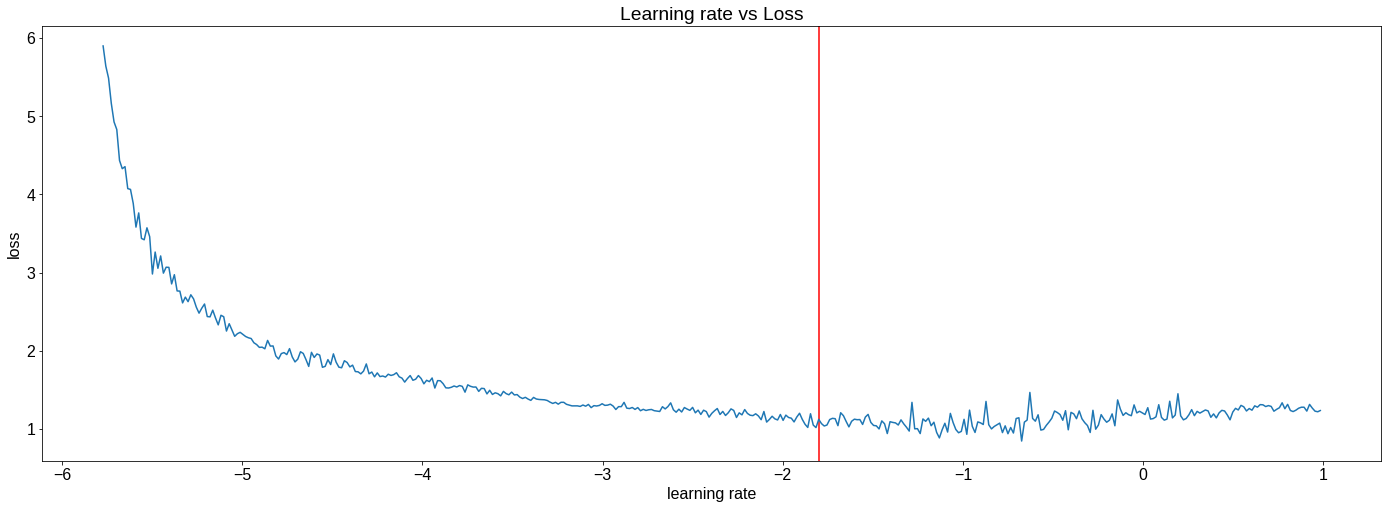

In [6]:
model = sm.FPN(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(None, None, CHANNELS))

lr_finder = LRFinder(num_samples=len(X_train), batch_size=BATCH_SIZE, minimum_lr=1e-6, maximum_lr=10, verbose=0)
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss)

model.fit_generator(generator=train_generator_pt1, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    epochs=1, 
                    callbacks=[lr_finder])

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(24, 8))
plt.axvline(x=np.log10(LEARNING_RATE), color='red')
lr_finder.plot_schedule(clip_beginning=15)

# Model PT 1

In [7]:
model = sm.FPN(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(None, None, CHANNELS))

oneCycleLR = OneCycleLR(max_lr=LEARNING_RATE, maximum_momentum=0.9, minimum_momentum=0.9, 
                        epochs=EPOCHS_PT1, batch_size=BATCH_SIZE, samples=len(X_train), steps=STEP_SIZE_TRAIN)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [oneCycleLR]
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [8]:
history = model.fit_generator(generator=train_generator_pt1,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator_pt1,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS_PT1,
                              verbose=2).history

Epoch 1/5


/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.444403). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 432s - loss: 1.0854 - dice_coef: 0.3228 - iou_score: 0.1906 - f1-score: 0.3119 - val_loss: 1.0015 - val_dice_coef: 0.4424 - val_iou_score: 0.2777 - val_f1-score: 0.4224
 - lr: 0.00791 - momentum: 0.90 
Epoch 2/5
 - 455s - loss: 0.9389 - dice_coef: 0.4269 - iou_score: 0.2692 - f1-score: 0.4137 - val_loss: 0.8546 - val_dice_coef: 0.4914 - val_iou_score: 0.3066 - val_f1-score: 0.4537
 - lr: 0.01425 - momentum: 0.90 
Epoch 3/5
 - 409s - loss: 0.8941 - dice_coef: 0.4593 - iou_score: 0.2949 - f1-score: 0.4438 - val_loss: 0.8352 - val_dice_coef: 0.5252 - val_iou_score: 0.3460 - val_f1-score: 0.4987
 - lr: 0.01111 - momentum: 0.90 
Epoch 4/5
 - 452s - loss: 0.8614 - dice_coef: 0.4786 - iou_score: 0.3129 - f1-score: 0.4649 - val_loss: 0.7917 - val_dice_coef: 0.5309 - val_iou_score: 0.3482 - val_f1-score: 0.5016
 - lr: 0.00477 - momentum: 0.90 
Epoch 5/5
 - 437s - loss: 0.8400 - dice_coef: 0.4902 - iou_score: 0.3235 - f1-score: 0.4770 - val_loss: 0.6763 - val_dice_coef: 0.5341 - val_iou_score

# Model

In [9]:
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
oneCycleLR = OneCycleLR(max_lr=LEARNING_RATE, maximum_momentum=0.9, minimum_momentum=0.9, 
                        epochs=EPOCHS_PT1, batch_size=BATCH_SIZE, samples=len(X_train), steps=STEP_SIZE_TRAIN)


metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, oneCycleLR]
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [10]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/15


/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.639583). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 590s - loss: 0.8595 - dice_coef: 0.4825 - iou_score: 0.3156 - f1-score: 0.4684 - val_loss: 0.8154 - val_dice_coef: 0.5323 - val_iou_score: 0.3508 - val_f1-score: 0.5037
 - lr: 0.00791 - momentum: 0.90 
Epoch 2/15
 - 566s - loss: 0.8634 - dice_coef: 0.4816 - iou_score: 0.3147 - f1-score: 0.4672 - val_loss: 0.9198 - val_dice_coef: 0.5262 - val_iou_score: 0.3395 - val_f1-score: 0.4905
 - lr: 0.01425 - momentum: 0.90 
Epoch 3/15
 - 561s - loss: 0.8542 - dice_coef: 0.4884 - iou_score: 0.3205 - f1-score: 0.4739 - val_loss: 0.5938 - val_dice_coef: 0.5387 - val_iou_score: 0.3581 - val_f1-score: 0.5120
 - lr: 0.01111 - momentum: 0.90 
Epoch 4/15
 - 532s - loss: 0.8437 - dice_coef: 0.4937 - iou_score: 0.3242 - f1-score: 0.4779 - val_loss: 0.7997 - val_dice_coef: 0.5421 - val_iou_score: 0.3569 - val_f1-score: 0.5094
 - lr: 0.00477 - momentum: 0.90 
Epoch 5/15
 - 539s - loss: 0.8276 - dice_coef: 0.5023 - iou_score: 0.3329 - f1-score: 0.4874 - val_loss: 0.8838 - val_dice_coef: 0.5472 - val_iou_s

## Model loss graph

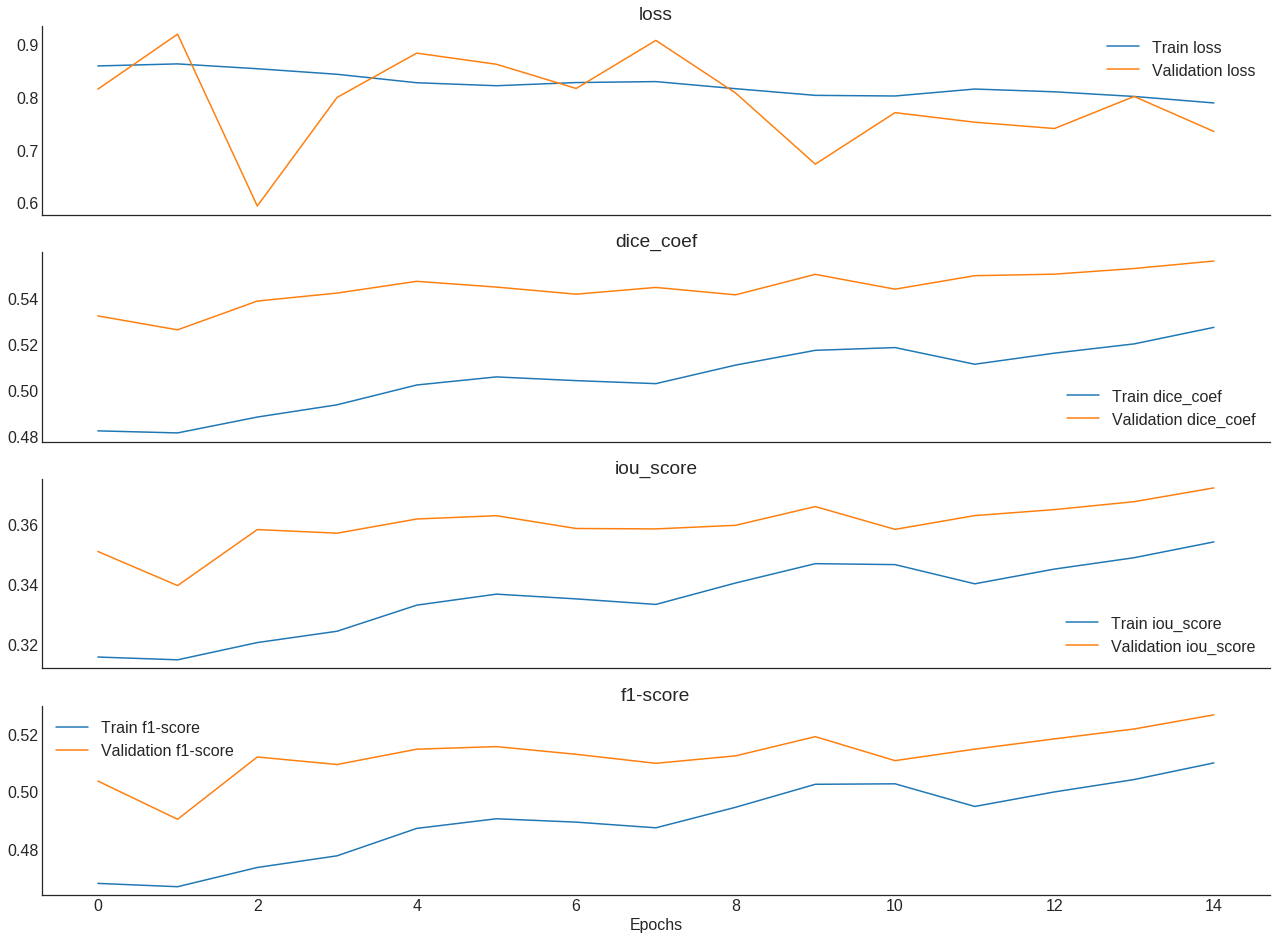

In [11]:
plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'f1-score'])

In [12]:
from keras.models import save_model
save_model(model, '71-fold2_fpn_%s_%sx%s_last.h5' % (BACKBONE, HEIGHT, WIDTH))